In [1]:
# import packages 
from skimage import io, transform
import numpy as np
import open3d as o3d
import copy
import napari
import time
import os

from skimage import morphology
from skimage.measure import label, regionprops, block_reduce
from scipy import stats, ndimage
import matplotlib.pyplot as plt
import sys

root_dir = os.path.join(os.getcwd(), '..')
sys.path.append(root_dir)


from src.preprocess import segmentation_with_optimized_thresh, image_padding
from src.registration import image_to_pcd, pcd_to_image

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# Read the image, only fluorescence channel is required:
#reference_fly_filename = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/01_raw/multiple/C1-220228_D2xEn-Gal4_1.tif"
#reference_fly_filename = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/01_raw/multiple/C1-220312_D2xEn-Gal4_2.tif"
#reference_fly_filename = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/01_raw/multiple/C1-220320_D6xEn-Gal4_2.tif"
reference_fly_filename = "../../data_2/01_raw/multiple/C1-220528_D3-4xEn-Gal4_1.tif"
#reference_fly_filename = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/01_raw/multiple/C1-220228_D6xEn-Gal4_1.tif"

image = io.imread(reference_fly_filename)

# Downscaling:
downscaling =  (1,2.5,2.5)
new_image_shape = [int(image.shape[i]/downscaling[i]) for i in range(3)]
image_downscaled = transform.resize(image, new_image_shape, preserve_range = True, anti_aliasing=True)
#image_downscaled = transform.downscale_local_mean(image, downscaling)[1:-2,1:-2,1:-2]
viewer = napari.view_image(image_downscaled)

In [12]:
t0 = time.time()
# Segment:
Thresholded_Image = segmentation_with_optimized_thresh(image_downscaled, fraction_range = [0.04, 0.05])
#viewer = napari.view_image(Thresholded_Image)

# Padding:
Thresholded_Image  = image_padding(Thresholded_Image)
Image_padded = image_padding(image_downscaled)

# Clean up the segmentation with morphological transformations:
closing_r1 = 4

# Dilate and erode again to fill small holes:
filled = morphology.closing(Thresholded_Image, morphology.ball(closing_r1))

label_image = label(filled)
rp = regionprops(label_image)
size = max([i.area for i in rp])

biggest_objects = morphology.remove_small_objects(label_image, min_size=size/10)>0
Thresholded_Image = biggest_objects

# fill small holes in the segmented image:
from scipy.signal import find_peaks

def local_maxima_z(image, dist):
    # maxima along z
    result = np.zeros(image.shape)
    
    for i in range(image.shape[1]):
        for j in range(image.shape[2]):
            peaks, _ = find_peaks(image[:,i,j], distance = dist)
            for p in peaks:
                result[p,i,j] = 1
    
    return result

Thresholded_Image = local_maxima_z(Thresholded_Image*Image_padded, 100)
#reduced = morphology.dilation(reduced, morphology.ball(10))

t1 = time.time()
viewer = napari.view_image(Thresholded_Image)
# print running time:

print("Preprocessing of the image took: ", t1-t0, "seconds")
"""

"""

Preprocessing of the image took:  10.044838428497314 seconds


'\n\n'

In [13]:
def custom_draw(pcd):
    # The following code achieves the same effect as:
    # o3d.visualization.draw_geometries([pcd])
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    opt = vis.get_render_option()
    opt.background_color = np.asarray([0, 0, 0])
    vis.add_geometry(pcd)
    vis.run()
    vis.destroy_window()
    
def custom_draw_w_mesh(pcd, mesh):
    # The following code achieves the same effect as:
    # o3d.visualization.draw_geometries([pcd])
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    opt = vis.get_render_option()
    opt.background_color = np.asarray([0, 0, 0])
    vis.add_geometry(pcd)
    vis.add_geometry(mesh)
    vis.run()
    vis.destroy_window()
    
def draw_pcd(pcd):
    pcd_temp = copy.deepcopy(pcd)
    pcd_temp.paint_uniform_color([1, 0.706, 0])
    o3d.visualization.draw_geometries([pcd_temp])
    

def skeletonize_on_slices(image_3d):
    
    result = np.zeros(image_3d.shape)
    
    for i in range(image_3d.shape[1]):
        image = image_3d[:,i,:]
        skeleton = morphology.skeletonize(image)
        result[:,i,:] = skeleton

    return result
    

# Create a pcd from the skeletonized image
pcd, pcd_values = image_to_pcd(Thresholded_Image)
custom_draw(pcd)

# Remove outliers from the skeletonized pcd, based on n_neighbrours within a radius:
uni_down_pcd = pcd.uniform_down_sample(every_k_points=3)
custom_draw(uni_down_pcd)
cleaned_pcd, ind = uni_down_pcd.remove_radius_outlier(nb_points=4, radius=4)
cleaned_pcd, ind = cleaned_pcd.remove_radius_outlier(nb_points=4, radius=4)
cleaned_pcd, ind = cleaned_pcd.remove_radius_outlier(nb_points=4, radius=3)

# downsampling
cleaned_pcd = cleaned_pcd.voxel_down_sample(voxel_size=5)

custom_draw(cleaned_pcd)

In [14]:
# Create a mesh that fits through the cleaned points to fill potential holes:
cleaned_pcd.estimate_normals()
cleaned_pcd.orient_normals_consistent_tangent_plane(k=30)

#flip normals:
normals = -np.asarray(cleaned_pcd.normals)
cleaned_pcd.normals = o3d.utility.Vector3dVector(normals)

#visualize normals:
#o3d.visualization.draw_geometries([cleaned_pcd], point_show_normal=True)

radii = [30]
ball_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(cleaned_pcd, o3d.utility.DoubleVector(radii))
bbox = cleaned_pcd.get_axis_aligned_bounding_box()
ball_mesh_crop = ball_mesh.crop(bbox)
ball_mesh_crop.paint_uniform_color([1,1,1])

custom_draw_w_mesh(cleaned_pcd, ball_mesh_crop)
resampled_pcd = ball_mesh_crop.sample_points_uniformly(number_of_points = 50000)
custom_draw(resampled_pcd)
#final_pcd = ball_mesh_crop.sample_points_uniformly(number_of_points = 5000)

final_pcd = o3d.geometry.PointCloud()
final_pcd.points = o3d.utility.Vector3dVector( np.concatenate((pcd.points, resampled_pcd.points), axis=0) )

custom_draw(final_pcd)

#o3d.visualization.draw_geometries([cleaned_pcd, p_mesh_crop])

In [15]:
final_pcd_values = np.ones(np.asarray(final_pcd.points).shape[0])
final_image = pcd_to_image(final_pcd, final_pcd_values, Thresholded_Image.shape)
final_image = morphology.dilation(final_image, morphology.ball(8))

In [16]:
viewer = napari.view_image(final_image*Image_padded)

In [17]:
# Save it as reference
from tifffile import imsave
imsave("../../data_2/References_and_masks/C1_Reference_iso.tiff", (final_image*Image_padded).astype(np.uint16))

In [28]:
### Testing prealignment and how to make the segmented volume thinner:
segmented_image = (final_image*Image_padded).astype(np.uint16)
from scipy.signal import find_peaks

def local_maxima_xyz(image, dist):
    # maxima along z
    result = np.zeros(image.shape)
    
    for i in range(image.shape[1]):
        for j in range(image.shape[2]):
            peaks, _ = find_peaks(image[:,i,j], distance = dist)
            for p in peaks:
                result[p,i,j] = 1
    
#    for i in range(image.shape[0]):
#        for j in range(image.shape[2]):
#            peaks, _ = find_peaks(image[i,:,j], distance = dist)
#            for p in peaks:
#                result[i,p,j] = 1
#                
#    for i in range(image.shape[0]):
#        for j in range(image.shape[1]):
#            peaks, _ = find_peaks(image[i,j,:], distance = dist)
#            for p in peaks:
#                result[i,j,p] = 1
    
    return result

reduced = local_maxima_xyz(segmented_image, 100)
reduced = morphology.dilation(reduced, morphology.ball(12))
viewer = napari.view_image(reduced)

[[-0.98360356 -0.18034423]
 [ 0.18034423 -0.98360356]]


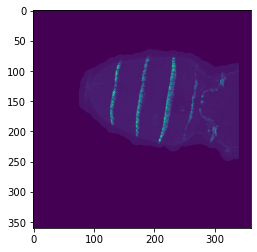

In [69]:
### Testing prealignment and how to make the segmented volume thinner:

segmented_image = (final_image*Image_padded).astype(np.uint16)
z_projected = np.max(segmented_image, axis= 0)
xy = np.argwhere(z_projected>1)
cov_xy = np.cov(xy.T)
_ , eigv = np.linalg.eig(cov_xy)
print(eigv)
plt.imshow(z_projected)

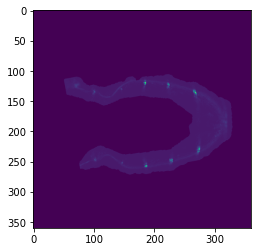

In [70]:
angle = -10*(np.pi)/180
angle = np.arctan2(eigv[1,0],eigv[0,0])

cth = np.cos(angle)
sth = np.sin(angle)

new_x = cth*np.mean(xy[:,0])-sth*np.mean(xy[:,1])
new_y = sth*np.mean(xy[:,0])+cth*np.mean(xy[:,1])
delta_x = z_projected.shape[0]/2-new_x
delta_y = z_projected.shape[1]/2-new_y

Matrix = np.array([[1, 0, 0, 0], 
                   [0,  cth, -sth, delta_x], 
                   [0, sth, cth, delta_y], 
                   [0, 0, 0, 1]])

rotated_image = ndimage.affine_transform(segmented_image, Matrix)
z_rot_projected = np.max(rotated_image, axis= 0)
plt.imshow(rotated_image[20,:,:])

In [74]:
np.argmax(np.bincount((segmented_image[segmented_image>0])))

223

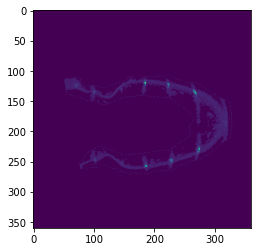

In [77]:
rotated_image[rotated_image<230] = 0
plt.imshow(rotated_image[20,:,:])

In [ ]:
from tifffile import imsave
output_file_name = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/temp/temp_final.tif"
imsave(output_file_name, final_image)

output_file_name = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/temp/temp_final_colored.tif"
imsave(output_file_name, final_image*Image_padded)

In [ ]:
def prealignment(source, target_pcd, force_flipping = False):
    target_mean, target_cov = target_pcd.compute_mean_and_covariance()
    source_mean, source_cov = source.compute_mean_and_covariance()
    _ , source_eigv = np.linalg.eig(source_cov)

    # transform to a base given by the x-y projection of the first eigenvector (0,b,c), 
    # the z-direction (0,0,1) and their vector product: (0,c,-b)
    
    b = source_eigv[1,0]
    c = source_eigv[2,0]
    b, c = b/(b**2+c**2)**0.5, c/(b**2+c**2)**0.5
    temp = np.asarray([[1.0, 0.0, 0.0], [0.0, b, c], [0.0, c, -b]])
    transformation_1 = np.eye(4)
    transformation_1[:3, :3] = np.linalg.inv(temp)
    
    temp = np.asarray([[1.0, 0.0, 0.0], [0.0, -b, -c], [0.0, -c, b]])
    transformation_2 = np.eye(4)
    transformation_2[:3, :3] = np.linalg.inv(temp)
    
    test_1 = copy.deepcopy(source)
    test_1.translate(-source_mean)
    test_1.transform(transformation_1)
    test_1.translate(target_mean)
    
    distances = test_1.compute_point_cloud_distance(target_pcd)
    dist_1 = np.sum(np.asarray(distances))
    
    test_2 = copy.deepcopy(source)
    test_2.translate(-source_mean)
    test_2.transform(transformation_2)
    test_2.translate(target_mean)
    
    distances = test_2.compute_point_cloud_distance(target_pcd)
    dist_2 = np.sum(np.asarray(distances))

    
    orientation = _choose_best_orientation_gui(test_1, test_2, target_pcd)
    print(orientation)
    if orientation == 1:
        return test_1
    else:
        return test_2
    
    
def refine_registration(source, target, threshold):
    result = o3d.pipelines.registration.registration_icp(
        source, target, threshold, np.identity(4),
        o3d.pipelines.registration.TransformationEstimationPointToPoint(with_scaling=False))
    return result

def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp =  source_temp.voxel_down_sample(voxel_size=4)
    target_temp =  target_temp.voxel_down_sample(voxel_size=4)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    opt = vis.get_render_option()
    opt.background_color = np.asarray([0, 0, 0])
    vis.add_geometry(source_temp)
    vis.add_geometry(target_temp)
    vis.run()
    vis.destroy_window()


def pcd_to_image(pcd,values, image_shape):
    array = np.asarray(pcd.points).T.astype(int)
    image = np.zeros(image_shape)
    count = np.zeros(image_shape)
    for i in range(array.shape[-1]):
        pos = tuple(array[...,i])
        image[pos] += values[i]
        count[pos] += 1
    image[count>1] = image[count>1]/count[count>1]
    mask = morphology.closing(image>0, morphology.ball(2))
    image_median = ndimage.median_filter(image, size=3)
    image[count==0] = image_median[count==0]
    image = image*mask
    return image

def image_to_pcd(image):
    indexes = np.nonzero(image > 0)
    pcd_points = np.array(indexes).T
    pcd_values = image[indexes]
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pcd_points)
    return pcd, pcd_values

def custom_draw_2(pcd):
    # The following code achieves the same effect as:
    # o3d.visualization.draw_geometries([pcd])
    pcd_tmp = copy.deepcopy(pcd)
    pcd_tmp =  pcd.voxel_down_sample(voxel_size=4)
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    opt = vis.get_render_option()
    opt.background_color = np.asarray([0, 0, 0])
    vis.add_geometry(pcd_tmp)
    vis.run()
    vis.destroy_window()

def _choose_best_orientation_gui(source_1, source_2, target):

    source_1_temp = copy.deepcopy(source_1)
    source_2_temp = copy.deepcopy(source_2)
    target_temp = copy.deepcopy(target)
    
    source_1_temp =  source_1_temp.voxel_down_sample(voxel_size=10)
    source_2_temp =  source_2_temp.voxel_down_sample(voxel_size=10)
    target_temp =  target_temp.voxel_down_sample(voxel_size=10)
    
    source_1_temp.paint_uniform_color([1, 0.706, 0])
    source_2_temp.paint_uniform_color([1, 0.606, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    
    
    vis = o3d.visualization.VisualizerWithKeyCallback()
    
    def press_1(vis, action, mods):
        nonlocal orientation
        orientation = 1
        try:
            vis.remove_geometry(source_2_temp)
        except:
            pass
            
        vis.add_geometry(source_1_temp)
        #vis.update_geometry()
        return
    
    def press_2(vis, action, mods):
        nonlocal orientation
        orientation = 2
        try:
            vis.remove_geometry(source_1_temp)
        except:
            pass
        vis.add_geometry(source_2_temp)
        #vis.update_geometry()
        return

    # key_action_callback will be triggered when there's a keyboard press, release or repeat event
    # for on of the following keys, correspondence based on GLFW keyboard keys 
    # (https://www.glfw.org/docs/latest/group__keys.html) :
    vis.register_key_action_callback(49, press_1)  # pressing key 1
    vis.register_key_action_callback(50, press_2)  # pressing key 2

    vis.create_window()
    
    orientation = 1
    vis.add_geometry(source_1_temp)
    vis.add_geometry(target_temp)
    vis.run()
    
    return orientation

### test registration without color:

In [ ]:
# Test registration:

# Read files and create point clouds
reference_fly_filename = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/References_and_masks/Reference_abdomen_binary_2_2_2.tif"
abdomen_mask_file = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/References_and_masks/Reference_abdomen_mask_thick_2_2_2.tif"

#source_file_name = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/temp/temp_final.tif"
#source_file_name = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/02_preprocessed/Preprocessed_C1-25_2_D2xEn-Gal4_1.tif"
#source_file_name = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/02_preprocessed/Preprocessed_C1-28_2_D2xEn-Gal4_1.tif"
source_file_name = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/02_preprocessed/Preprocessed_C1-28_2_D2xEn-Gal4_2.tif"
#source_file_name = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/02_preprocessed/Preprocessed_C1-28_2_D6xEn-Gal4_1.tif"
#source_file_name = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/02_preprocessed/Preprocessed_C1-220313_D6xEn-Gal4_1.tif"
#source_file_name = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/02_preprocessed/Preprocessed_C1-220313_D2xEn-Gal4_1.tif"

#source_file_name_dsred = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/temp/temp_final.tif"
#source_file_name_dsred = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/02_preprocessed/Preprocessed_C2-25_2_D2xEn-Gal4_1.tif"
#source_file_name_dsred = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/02_preprocessed/Preprocessed_C2-28_2_D2xEn-Gal4_1.tif"
source_file_name_dsred = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/02_preprocessed/Preprocessed_C2-28_2_D2xEn-Gal4_2.tif"
#source_file_name_dsred = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/02_preprocessed/Preprocessed_C2-28_2_D6xEn-Gal4_1.tif"
#source_file_name_dsred = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/02_preprocessed/Preprocessed_C2-220313_D6xEn-Gal4_1.tif"
#source_file_name_dsred = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/02_preprocessed/Preprocessed_C2-220313_D2xEn-Gal4_1.tif"


Reference_Image = io.imread(reference_fly_filename)
Abdomen_Mask = io.imread(abdomen_mask_file)
Source_Image = io.imread(source_file_name)
Source_dsred = io.imread(source_file_name_dsred)

#Source_TL = segmented_image_TL
source, Source_values = image_to_pcd(Source_Image)
source_dsred, Source_values_dsred = image_to_pcd(Source_dsred)

target, Target_values = image_to_pcd(Reference_Image)

source.paint_uniform_color([1, 0.706, 0])
target.paint_uniform_color([0, 0.651, 0.929])

source = prealignment(source,target, force_flipping = True)

In [ ]:
# Preliminary alignment:
#source = prealignment(source,target, force_flipping = True)
#radius = 10
source_down = source.voxel_down_sample(radius)
target_down = target.voxel_down_sample(radius)

#custom_draw_2(source_down)

draw_registration_result(source_down, target_down, np.eye(4))

In [ ]:
def refine_registration_PointToPlane(source, target, threshold, downsampling_radius):
    # downsampling to accelerate computation:
    source_down = source.voxel_down_sample(downsampling_radius)
    target_down = target.voxel_down_sample(downsampling_radius)
    
    # computing the normals for each point:
    source_down.estimate_normals()
    source_down.orient_normals_consistent_tangent_plane(k=30)

    target_down.estimate_normals()
    target_down.orient_normals_consistent_tangent_plane(k=30)
    
    result = o3d.pipelines.registration.registration_icp(
        source_down, target_down, threshold, np.identity(4),
        o3d.pipelines.registration.TransformationEstimationPointToPlane(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=500))
    return result

def refine_registration_PoinToPoint_Scaling(source, target, threshold):
    result = o3d.pipelines.registration.registration_icp(
        source, target, threshold, np.identity(4),
        o3d.pipelines.registration.TransformationEstimationPointToPoint(with_scaling=True))
    return result

# Refine registration with Point to plane ICP:
result_icp = refine_registration_PointToPlane(source, target, 50, 5)

print(result_icp)
after_icp = copy.deepcopy(source_down)
after_icp.transform(result_icp.transformation)
draw_registration_result(after_icp, target_down, np.eye(4))

registered_source_image = pcd_to_image(after_icp, Source_values, Reference_Image.shape)
registered_source_image_dsred = pcd_to_image(after_icp, Source_values_dsred, Reference_Image.shape)

final_image = registered_source_image*Abdomen_Mask
final_image_dsred = registered_source_image_dsred*Abdomen_Mask

#viewer1 = napari.view_image(final_image)
#viewer2 = napari.view_image(final_image_dsred)


In [ ]:
from tifffile import imsave
output_file_name = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/temp/Registered_C1-220313_D2xEn-Gal4_1.tif"
imsave(output_file_name, final_image)

output_file_name = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/temp/Registered_C2-220313_D2xEn-Gal4_1.tif"
imsave(output_file_name, final_image_dsred)

In [ ]:
draw_registration_result(after_icp, target, np.eye(4))

### Testing colored registration

In [ ]:
# Test registration:

# Read files and create point clouds
reference_fly_filename = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/References_and_masks/Reference_abdomen_2_2_2.tif"
abdomen_mask_file = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/References_and_masks/Reference_abdomen_mask_2_2_2.tif"
source_file_name = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/temp/temp_final_colored.tif"

Reference_Image = io.imread(reference_fly_filename)
Abdomen_Mask = io.imread(abdomen_mask_file)
Source_Image = io.imread(source_file_name)
#Source_DsRed = 

source, Source_values = image_to_pcd(Source_Image)
bw_colors = Source_values/np.max(Source_values)
source.colors = o3d.utility.Vector3dVector(np.asarray([bw_colors, bw_colors, bw_colors]).T)

#source_DsRed, Source_values_DsRed = image_to_pcd(Source_DsRed)

target, Target_values = image_to_pcd(Reference_Image)
bw_colors = Target_values/np.max(Target_values)
target.colors = o3d.utility.Vector3dVector(np.asarray([bw_colors, bw_colors, bw_colors]).T)

o3d.visualization.draw_geometries([source, target])

In [ ]:
# Preliminary alignment:
source = prealignment(source,target)
radius = 20
source_down = source.voxel_down_sample(radius)
target_down = target.voxel_down_sample(radius)

draw_registration_result(source_down, target_down, np.eye(4))

In [ ]:
def refine_registration_PointToPlane(source, target, threshold):
    "threshold = max distance between corresponding points"
    print("starting icp")
    result = o3d.pipelines.registration.registration_icp(
        source, target, threshold, np.identity(4),
        o3d.pipelines.registration.TransformationEstimationPointToPlane(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=300))
    return result


source_down.estimate_normals()
source_down.orient_normals_consistent_tangent_plane(k=30)

target_down.estimate_normals()
target_down.orient_normals_consistent_tangent_plane(k=30)

# Initialize registration with Point to plane ICP:
result_icp = refine_registration_PointToPlane(source_down, target_down, 50)
after_icp = copy.deepcopy(source)
after_icp.transform(result_icp.transformation)
draw_registration_result(after_icp, target, np.eye(4))

In [ ]:
# Registration with Colored point clouds
radius = 10
threshold = 100
max_iters = 1000

source_down = after_icp.voxel_down_sample(radius)
target_down = target.voxel_down_sample(radius)

source_down.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=radius * 2, max_nn=30))
target_down.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=radius * 2, max_nn=30))

current_transformation = np.identity(4)

result_icp = o3d.pipelines.registration.registration_colored_icp(
        source_down, target_down, threshold, current_transformation,
        o3d.pipelines.registration.TransformationEstimationForColoredICP(lambda_geometric=1),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=max_iters))

current_transformation = result_icp.transformation

after_cicp = copy.deepcopy(after_icp)
after_cicp.transform(current_transformation)

print(result_icp)

draw_registration_result(after_cicp, target, np.eye(4))

# testing projection


In [ ]:
source_file_name = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/03_registered/Registered_C1-220313_D2xEn-Gal4_1.tif"
source_file_name_dsred = "/media/ceolin/Data/Lab Gompel/Projects/Fly_Abdomens/data_2/03_registered/Registered_C2-220313_D2xEn-Gal4_1.tif"


def project_2D(pcd, values, bins_x1, bins_x2):
    
    indexes = np.asarray(pcd.points).T
    
    x = indexes[2,:]-200
    y = indexes[1,:]-337
    z = indexes[0,:]-10
    
    
    x1 = -0.43*x-0.9*y
    y1 = -0.9*x+0.43*y
    
    theta = np.arctan2(y1, z)
    
    ret = stats.binned_statistic_2d(theta, x1, values, statistic='max', bins=[bins_x1, bins_x2], range=None, expand_binnumbers=False)
    final_image = ret.statistic
    
    return final_image

n_bins_1 = 100
n_bins_2 = 100

Source_gfp = io.imread(source_file_name)
Source_dsred = io.imread(source_file_name_dsred)

final_pcd, final_values = image_to_pcd(Source_gfp)
final_pcd_dsred, final_values_dsred = image_to_pcd(Source_dsred)
    
bins_1 = np.linspace(-2,2,n_bins_1)
bins_2 = np.linspace(0,370,n_bins_2)
    
projected_image = project_2D(final_pcd, final_values, bins_1, bins_2)
projected_image_TL = project_2D(final_pcd, final_values_dsred, bins_1, bins_2)  

plt.imshow(projected_image)